### Data Description:
####  The dataset is composed of the On Board Diagnostics (OBD) Data from 14 drivers, driving their cars in daily routes. In particular, data is recorded only for the Power Train Module, and also contains the metadata of the cars.

### Objective:
#### 1. Find the relationship between DTC code's P007E/F (given under TROUBLE_CODES column) and given sensor data
#### 2. Data stats summary - includes the exercise of identifying what each field is likely representing and understanding the data set
#### 3. Exploration of each variable - Univariate analysis
#### 4. Relationship between P007E/F and each variable - Bivariate analysis
#### 5. Insights from the data set

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
data = pd.read_csv(r'C:\Users\raksh\vehicle-health-prediction-obd2-dataset\dataset.csv')
data.head()

C:\Users\raksh\AppData\Local\Temp\ipykernel_15496\573636375.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'C:\Users\raksh\vehicle-health-prediction-obd2-dataset\dataset.csv')


,TIMESTAMP,MARK,MODEL,CAR_YEAR,ENGINE_POWER,AUTOMATIC,VEHICLE_ID,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,...,THROTTLE_POS,DTC_NUMBER,TROUBLE_CODES,TIMING_ADVANCE,EQUIV_RATIO,MIN,HOURS,DAYS_OF_WEEK,MONTHS,YEAR
0,1502902504267,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.569,0.01,13.0,16.0,2.0,8.0,2017.0
1,1502902512283,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.565,0.01,13.0,16.0,2.0,8.0,2017.0
2,1502902520291,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.573,0.01,13.0,16.0,2.0,8.0,2017.0
3,1502902528300,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.565,0.01,13.0,16.0,2.0,8.0,2017.0
4,1502902536320,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.569,0.01,13.0,16.0,2.0,8.0,2017.0


In [4]:
data[data['TROUBLE_CODES'].notnull()].shape,data.shape

((11925, 33), (47514, 33))

In [5]:
11925/47514
# just 25% of the data has the Trouble Codes logged in.

0.250978658921581

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TIMESTAMP                    47514 non-null  int64  
 1   MARK                         47459 non-null  object 
 2   MODEL                        47459 non-null  object 
 3   CAR_YEAR                     47459 non-null  float64
 4   ENGINE_POWER                 47459 non-null  float64
 5   AUTOMATIC                    47459 non-null  object 
 6   VEHICLE_ID                   47514 non-null  object 
 7   BAROMETRIC_PRESSURE(KPA)     10212 non-null  float64
 8   ENGINE_COOLANT_TEMP          33964 non-null  float64
 9   FUEL_LEVEL                   2994 non-null   float64
 10  ENGINE_LOAD                  30972 non-null  float64
 11  AMBIENT_AIR_TEMP             3619 non-null   float64
 12  ENGINE_RPM                   33859 non-null  float64
 13  INTAKE_MANIFOLD_

#### Data Stats Summary & Analysis

In [7]:
data['TROUBLE_CODES'].unique() # check the DTC (diagnostic trouble codes) codes present in the data and verify if our required codes are present
# we could observe that null values are present in the data

array([nan, 'P0133', 'C0300', 'P0079P2004P3000', 'P0078U1004P3000',
       'P0079C1004P3000', 'P007EP2036P18F0', 'P007EP2036P18D0',
       'P007FP2036P18D0', 'P0079P1004P3000', 'P007EP2036P18E0',
       'P007FP2036P18E0', 'P0078B0004P3000', 'P007FP2036P18F0'],
      dtype=object)

In [8]:
data = data.dropna(subset = ['TROUBLE_CODES']).reset_index(drop=True) # getting rid of null values from trouble codes
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], unit='ms') # converting Timestamp to proper format.

In [8]:
data.loc[(data['TROUBLE_CODES'].str.contains('P007E')) | (data['TROUBLE_CODES'].str.contains('P007F'))].info()
# checking data of interest for null values and data sparsity
# we could see some of the columns like FUEL_LEVEL, BAROMETRIC_PRESSURE(KPA)..etc having no data. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 11751 to 11924
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TIMESTAMP                    58 non-null     datetime64[ns]
 1   MAKE                         58 non-null     object        
 2   MODEL                        58 non-null     object        
 3   CAR_YEAR                     58 non-null     float64       
 4   ENGINE_POWER                 58 non-null     float64       
 5   AUTOMATIC                    58 non-null     object        
 6   VEHICLE_ID                   58 non-null     object        
 7   BAROMETRIC_PRESSURE(KPA)     0 non-null      float64       
 8   ENGINE_COOLANT_TEMP          54 non-null     float64       
 9   FUEL_LEVEL                   0 non-null      float64       
 10  ENGINE_LOAD                  58 non-null     float64       
 11  AMBIENT_AIR_TEMP             0 non-null 

In [9]:
data.loc[(data['TROUBLE_CODES'].str.contains('P007E')) | (data['TROUBLE_CODES'].str.contains('P007F'))]

,TIMESTAMP,MARK,MODEL,CAR_YEAR,ENGINE_POWER,AUTOMATIC,VEHICLE_ID,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,...,THROTTLE_POS,DTC_NUMBER,TROUBLE_CODES,TIMING_ADVANCE,EQUIV_RATIO,MIN,HOURS,DAYS_OF_WEEK,MONTHS,YEAR
11751,2017-08-30 11:04:27.390,citroen,c3,2013.0,1.4,n,car13,NaN,93.0,NaN,...,0.149,MIL is OFF0 codes,P007EP2036P18F0,0.494,NaN,46.0,10.0,2.0,8.0,2017.0
11752,2017-08-30 16:21:20.839,citroen,c3,2013.0,1.4,n,car13,NaN,71.0,NaN,...,0.157,MIL is OFF0 codes,P007EP2036P18D0,0.486,NaN,20.0,16.0,2.0,8.0,2017.0
11753,2017-08-30 16:21:32.853,citroen,c3,2013.0,1.4,n,car13,NaN,73.0,NaN,...,0.157,MIL is OFF0 codes,P007EP2036P18D0,0.545,NaN,20.0,16.0,2.0,8.0,2017.0
11754,2017-08-30 16:21:48.159,citroen,c3,2013.0,1.4,n,car13,NaN,NaN,NaN,...,0.208,MIL is OFF0 codes,P007FP2036P18D0,0.576,NaN,20.0,16.0,2.0,8.0,2017.0
11756,2017-08-30 16:22:04.906,citroen,c3,2013.0,1.4,n,car13,NaN,79.0,NaN,...,0.192,MIL is OFF0 codes,P007EP2036P18E0,0.522,NaN,20.0,16.0,2.0,8.0,2017.0
11757,2017-08-30 16:22:16.938,citroen,c3,2013.0,1.4,n,car13,NaN,81.0,NaN,...,0.169,MIL is OFF0 codes,P007FP2036P18E0,0.443,NaN,20.0,16.0,2.0,8.0,2017.0
11759,2017-08-30 16:22:28.956,citroen,c3,2013.0,1.4,n,car13,NaN,83.0,NaN,...,0.173,MIL is OFF0 codes,P007EP2036P18E0,0.412,NaN,20.0,16.0,2.0,8.0,2017.0
11761,2017-08-30 16:23:05.000,citroen,c3,2013.0,1.4,n,car13,NaN,88.0,NaN,...,0.161,MIL is OFF0 codes,P007EP2036P18E0,NaN,NaN,20.0,16.0,2.0,8.0,2017.0
11762,2017-08-30 16:23:17.005,citroen,c3,2013.0,1.4,n,car13,NaN,90.0,NaN,...,0.157,MIL is OFF0 codes,P007FP2036P18E0,0.576,NaN,20.0,16.0,2.0,8.0,2017.0
11763,2017-08-30 16:23:29.026,citroen,c3,2013.0,1.4,n,car13,NaN,91.0,NaN,...,0.157,MIL is OFF0 codes,P007EP2036P18E0,0.506,NaN,20.0,16.0,2.0,8.0,2017.0


In [10]:
58, 11925, 

(58, 11925)

In [11]:
data

,TIMESTAMP,MARK,MODEL,CAR_YEAR,ENGINE_POWER,AUTOMATIC,VEHICLE_ID,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,...,THROTTLE_POS,DTC_NUMBER,TROUBLE_CODES,TIMING_ADVANCE,EQUIV_RATIO,MIN,HOURS,DAYS_OF_WEEK,MONTHS,YEAR
0,2017-07-08 17:54:47.058,volkswagen,polo,2006.0,1.6,n,car6,NaN,42.0,NaN,...,0.043,MIL is OFF1 codes,P0133,0.714,NaN,53.0,18.0,5.0,7.0,2017.0
1,2017-07-08 17:54:59.071,volkswagen,polo,2006.0,1.6,n,car6,NaN,42.0,NaN,...,0.043,MIL is OFF1 codes,P0133,0.690,NaN,53.0,18.0,5.0,7.0,2017.0
2,2017-07-08 17:55:11.089,volkswagen,polo,2006.0,1.6,n,car6,NaN,43.0,NaN,...,0.043,MIL is OFF1 codes,P0133,0.506,NaN,53.0,18.0,5.0,7.0,2017.0
3,2017-07-08 17:55:23.101,volkswagen,polo,2006.0,1.6,n,car6,NaN,44.0,NaN,...,0.035,MIL is OFF1 codes,P0133,0.537,NaN,53.0,18.0,5.0,7.0,2017.0
4,2017-07-08 17:55:35.109,volkswagen,polo,2006.0,1.6,n,car6,NaN,45.0,NaN,...,0.031,MIL is OFF1 codes,P0133,0.541,NaN,53.0,18.0,5.0,7.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11920,2017-09-12 01:41:43.293,citroen,c3,2013.0,1.4,n,car13,NaN,NaN,NaN,...,0.173,MIL is OFF0 codes,P0079P2004P3000,0.396,NaN,33.0,1.0,1.0,9.0,2017.0
11921,2017-09-12 01:42:15.372,citroen,c3,2013.0,1.4,n,car13,NaN,92.0,NaN,...,0.247,MIL is OFF0 codes,P0078U1004P3000,0.596,NaN,33.0,1.0,1.0,9.0,2017.0
11922,2017-09-12 01:42:31.395,citroen,c3,2013.0,1.4,n,car13,NaN,92.0,NaN,...,0.235,MIL is OFF0 codes,P007EP2036P18D0,0.639,NaN,33.0,1.0,1.0,9.0,2017.0
11923,2017-09-12 01:42:39.412,citroen,c3,2013.0,1.4,n,car13,NaN,92.0,NaN,...,0.251,MIL is OFF0 codes,P0078U1004P3000,0.612,NaN,33.0,1.0,1.0,9.0,2017.0


In [12]:
data.loc[(data['TROUBLE_CODES'].str.contains('P007E')) | (data['TROUBLE_CODES'].str.contains('P007F'))].nunique()
# checking data of interest for unique & constant values
# we could see some of the columns like MAKE, MODEL, DTC_NUMBER having only single value for all the timestamps.

TIMESTAMP                      58
MARK                            1
MODEL                           1
CAR_YEAR                        1
ENGINE_POWER                    1
AUTOMATIC                       1
VEHICLE_ID                      1
BAROMETRIC_PRESSURE(KPA)        0
ENGINE_COOLANT_TEMP            21
FUEL_LEVEL                      0
ENGINE_LOAD                    46
AMBIENT_AIR_TEMP                0
ENGINE_RPM                     56
INTAKE_MANIFOLD_PRESSURE       33
MAF                             0
LONG TERM FUEL TRIM BANK 2      0
FUEL_TYPE                       0
AIR_INTAKE_TEMP                20
FUEL_PRESSURE                   0
SPEED                          34
SHORT TERM FUEL TRIM BANK 2     0
SHORT TERM FUEL TRIM BANK 1    17
ENGINE_RUNTIME                  0
THROTTLE_POS                   30
DTC_NUMBER                      1
TROUBLE_CODES                   6
TIMING_ADVANCE                 33
EQUIV_RATIO                     0
MIN                             9
HOURS         

In [18]:
req_data = data[['TIMESTAMP','TROUBLE_CODES','ENGINE_COOLANT_TEMP','ENGINE_LOAD','ENGINE_RPM','INTAKE_MANIFOLD_PRESSURE','AIR_INTAKE_TEMP','SPEED','SHORT TERM FUEL TRIM BANK 1','THROTTLE_POS','TIMING_ADVANCE']]
# from the data sanity checks we have selected the columns in the dataset which vary with time to play with. 
req_data.head()

,TIMESTAMP,TROUBLE_CODES,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,INTAKE_MANIFOLD_PRESSURE,AIR_INTAKE_TEMP,SPEED,SHORT TERM FUEL TRIM BANK 1,THROTTLE_POS,TIMING_ADVANCE
0,2017-07-08 17:54:47.058,P0133,42.0,0.063,1659.0,24.0,30.0,43.0,NaN,0.043,0.714
1,2017-07-08 17:54:59.071,P0133,42.0,0.067,1290.0,26.0,30.0,35.0,NaN,0.043,0.690
2,2017-07-08 17:55:11.089,P0133,43.0,0.075,1002.0,35.0,31.0,12.0,NaN,0.043,0.506
3,2017-07-08 17:55:23.101,P0133,44.0,0.055,872.0,33.0,30.0,0.0,NaN,0.035,0.537
4,2017-07-08 17:55:35.109,P0133,45.0,0.051,856.0,32.0,30.0,0.0,NaN,0.031,0.541


#### Univariate Analysis, Descriptive Stats and Imputation

In [19]:
req_data.iloc[:,1:].describe().round(2)
# checking the distributions of the sensor data - insights are given at the end of the script

,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,INTAKE_MANIFOLD_PRESSURE,AIR_INTAKE_TEMP,SPEED,SHORT TERM FUEL TRIM BANK 1,THROTTLE_POS,TIMING_ADVANCE
count,11873.00,11089.00,11837.00,11868.00,11875.00,11803.00,5817.00,11862.00,11885.00
mean,74.08,0.35,1400.46,43.46,40.25,27.14,-0.01,0.11,0.59
std,10.67,0.16,534.28,17.61,7.81,22.85,0.04,0.07,0.09
min,22.00,0.05,465.00,16.00,23.00,0.00,-0.25,0.02,0.32
25%,72.00,0.24,815.00,31.00,34.00,3.00,-0.03,0.05,0.52
50%,77.00,0.38,1414.00,40.00,40.00,26.00,-0.01,0.12,0.56
75%,80.00,0.41,1808.00,54.00,45.00,43.00,0.02,0.14,0.67
max,99.00,1.00,3256.00,101.00,63.00,105.00,0.18,0.86,0.82


In [23]:
req_data = req_data.interpolate()
# interpolating missing values in the sensor data

C:\Users\raksh\AppData\Local\Temp\ipykernel_15496\929304523.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  req_data = req_data.interpolate()


In [24]:
req_data.iloc[:,1:].describe().round(2)
# checking the distributions of the sensor data after interpolation - insights are given at the end of the script

,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,INTAKE_MANIFOLD_PRESSURE,AIR_INTAKE_TEMP,SPEED,SHORT TERM FUEL TRIM BANK 1,THROTTLE_POS,TIMING_ADVANCE
count,11925.00,11925.00,11925.00,11925.00,11925.00,11925.00,5855.00,11925.00,11925.00
mean,74.09,0.33,1399.37,43.48,40.26,27.03,-0.01,0.11,0.59
std,10.67,0.16,533.28,17.59,7.80,22.80,0.04,0.07,0.09
min,22.00,0.05,465.00,16.00,23.00,0.00,-0.25,0.02,0.32
25%,71.00,0.22,815.00,31.00,34.00,3.00,-0.03,0.05,0.52
50%,77.00,0.35,1412.00,40.00,40.00,26.00,0.00,0.12,0.56
75%,80.00,0.41,1806.00,54.00,45.00,43.00,0.02,0.14,0.67
max,99.00,1.00,3256.00,101.00,63.00,105.00,0.18,0.86,0.82


In [25]:
plt.figure(figsize = (15,5))
sns.heatmap(req_data.iloc[:,1:].corr(),annot=True)
# checking the correlations between the various sensor data - currently pearson correlation alone is taken into picture

ValueError: could not convert string to float: 'P0133'

<Figure size 1500x500 with 0 Axes>

### Univariate & Bivariate Analysis

#### In the dataset, 'TROUBLE_CODES' column is a categorical feature and remaining columns are continuous variables. 
#### There are three big-picture methods to understand if a continuous and categorical are significantly correlated — point biserial correlation, logistic regression, and Kruskal Wallis H Test.
#### Of the three, logistic regression is chosen to go forward and it helps to find relationship between trouble code's P007E, P007F and the continuous data.
####  If there is a relationship between the categorical and continuous variable, we should be able to construct an accurate predictor of the categorical variable from the continuous variable using logistic regression. If the resulting classifier has a high degree of fit, is accurate, sensitive, and specific we can conclude the two variables share a relationship and are indeed correlated.

In [26]:
req_data_1 = req_data[req_data.TROUBLE_CODES.str.contains('P007E')].reset_index(drop=True)
req_data_2 = req_data[req_data.TROUBLE_CODES.str.contains('P007F')].reset_index(drop=True)
# data slicing based on Trouble codes

In [27]:
req_data.shape

(11925, 11)

In [28]:
req_data_1.shape,req_data_2.shape

((47, 11), (11, 11))

#### Note:  Observing the dataset, we could see that the data is recorded with irregular frequency and so the dataset is imbalanced. So, for further analysis, we downsample the dataset to a daily frequency. There is cost associated if in future, we use this dataset for forecasting models as we are aggregating up the noises.

In [29]:
req_data_1 = req_data_1.set_index(req_data_1['TIMESTAMP']).resample('D').mean().reset_index().fillna(0)
req_data_1['TROUBLE_CODES'] = 'P007E'
req_data_2 = req_data_2.set_index(req_data_2['TIMESTAMP']).resample('D').mean().reset_index().fillna(0)
req_data_2['TROUBLE_CODES'] = 'P007F'
# generalizing trouble code column to two groups - P007E & P007F
combined_data_resampled = pd.concat([req_data_1,req_data_2],ignore_index=True,sort=True)

TypeError: agg function failed [how->mean,dtype->object]

In [30]:
# retaining original data for comparision with the resampled data
data1 = req_data[req_data.TROUBLE_CODES.str.contains('P007E')].reset_index(drop=True)
data2 = req_data[req_data.TROUBLE_CODES.str.contains('P007F')].reset_index(drop=True)
# data slicing based on Trouble codes
combined_data = pd.concat([data1,data2],ignore_index=True,sort=True)

In [31]:
X = combined_data.drop(columns={'TROUBLE_CODES','TIMESTAMP'})
y = combined_data['TROUBLE_CODES']
X_resampled = combined_data_resampled.drop(columns={'TROUBLE_CODES','TIMESTAMP'})
y_resampled = combined_data_resampled['TROUBLE_CODES']

NameError: name 'combined_data_resampled' is not defined

#### Engine Coolant Temperature

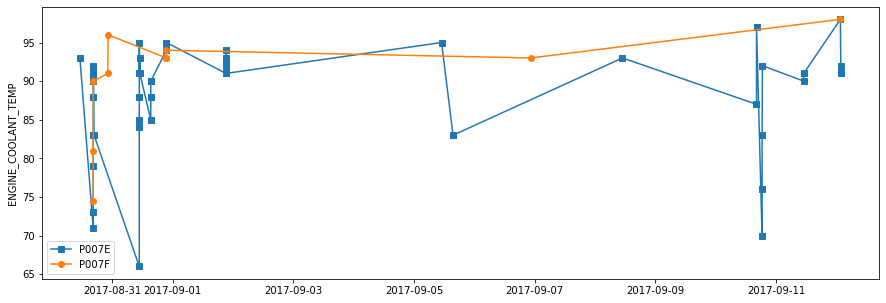

In [24]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['ENGINE_COOLANT_TEMP'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['ENGINE_COOLANT_TEMP'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_COOLANT_TEMP')
plt.show()

#For P007F DTC code, coolant temperature is high as the engine heats up due to the failure of bank 2.
# Dataset couldn't be downsampled as the trend of the data would drastically change for the given trouble codes.

In [25]:
data1['code'] = 1 # P007E
data2['code'] = 2 # P007F

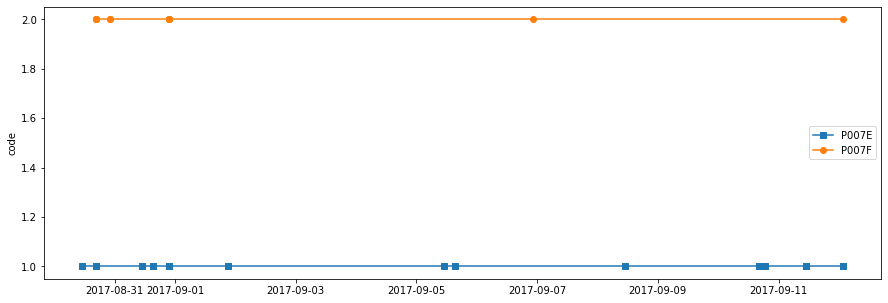

In [26]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['code'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['code'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('code')
plt.show()

#For P007F DTC code, coolant temperature is high as the engine heats up due to the failure of bank 2.
# Dataset couldn't be downsampled as the trend of the data would drastically change for the given trouble codes.

In [27]:
mdl1 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto').fit(np.array(X['ENGINE_COOLANT_TEMP']).reshape(-1,1) , y)
mdl1.score(np.array(X['ENGINE_COOLANT_TEMP']).reshape(-1,1),y)

# checking the accuracy of the classifier to decide on the relationship between sensor data and trouble code's
# accuracy score is low to set up a relationship

0.3275862068965517

In [28]:
mdl1.predict(np.array([114.1]).reshape(-1,1)),mdl1.predict(np.array([114.2]).reshape(-1,1))
# from the classifier model decision threshold of sensor data between the fault codes = 114.1

(array(['P007EP2036P18F0'], dtype=object),
 array(['P007EP2036P18F0'], dtype=object))

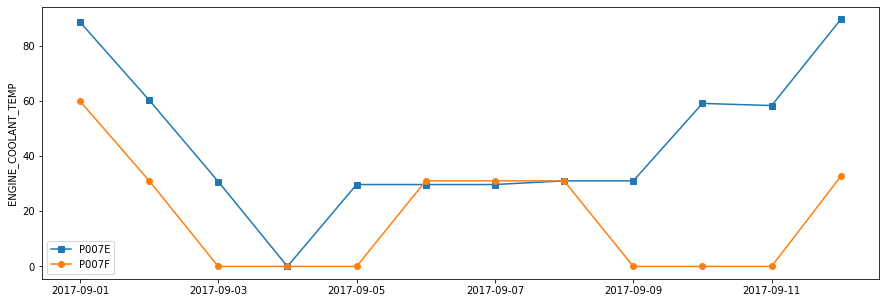

In [29]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['ENGINE_COOLANT_TEMP'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['ENGINE_COOLANT_TEMP'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_COOLANT_TEMP')
plt.show()
# after downsampling
# P007E - sensor value has a dip from sept 1st to sept 4th, and increases after september 9th. 
# P007F - sensor value decreases to 0 until sept 3rd, and follows a seasonal pattern afterwards.

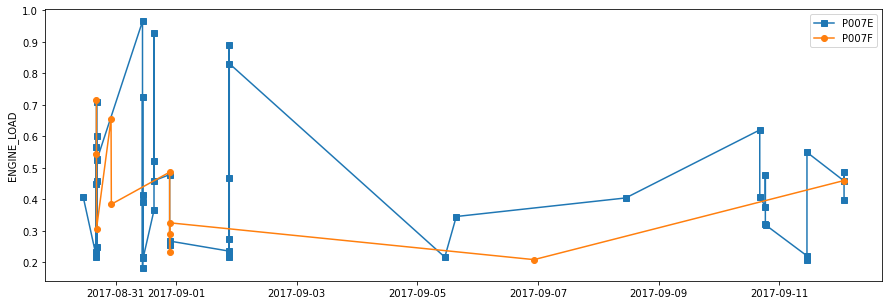

In [30]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['ENGINE_LOAD'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['ENGINE_LOAD'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_LOAD')
plt.show()

# Engine Loads are high for P007E codes in the initial timestamps.

In [31]:
mdl2 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto').fit(np.array(X['ENGINE_LOAD']).reshape(-1,1) , y)
mdl2.score(np.array(X['ENGINE_LOAD']).reshape(-1,1),y)

# checking the accuracy of the classifier to decide on the relationship between sensor data and trouble code's
# accuracy score is low to set up a relationship

0.39655172413793105

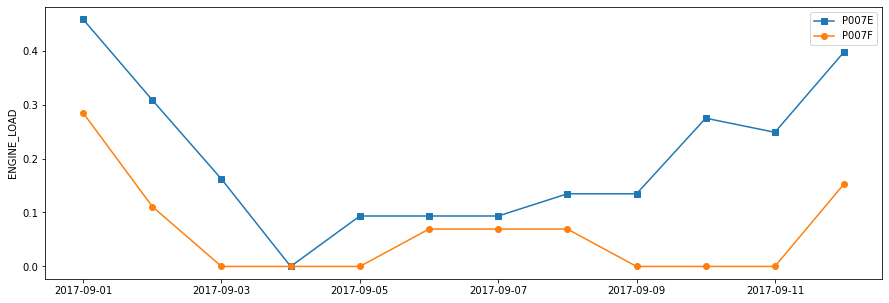

In [32]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['ENGINE_LOAD'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['ENGINE_LOAD'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_LOAD')
plt.show()
# after downsampling
# P007E - sensor value has a dip from sept 1st to sept 4th, and increases after september 9th. 
# P007F - sensor value decreases to 0 until sept 3rd, and follows a seasonal pattern afterwards.

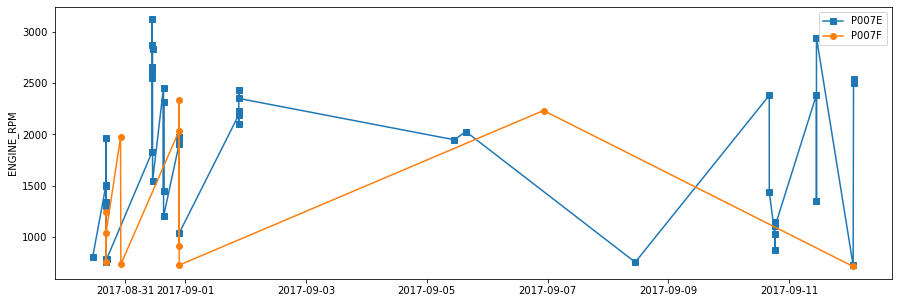

In [33]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['ENGINE_RPM'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['ENGINE_RPM'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_RPM')
plt.show()

# ENGINE_RPM doesn't follow a specific trend for both P007E and P007F codes.

In [34]:
mdl3 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto').fit(np.array(X['ENGINE_RPM']).reshape(-1,1) , y)
mdl3.score(np.array(X['ENGINE_RPM']).reshape(-1,1),y)

# checking the accuracy of the classifier to decide on the relationship between sensor data and trouble code's
# accuracy score is low to set up a relationship

0.3620689655172414

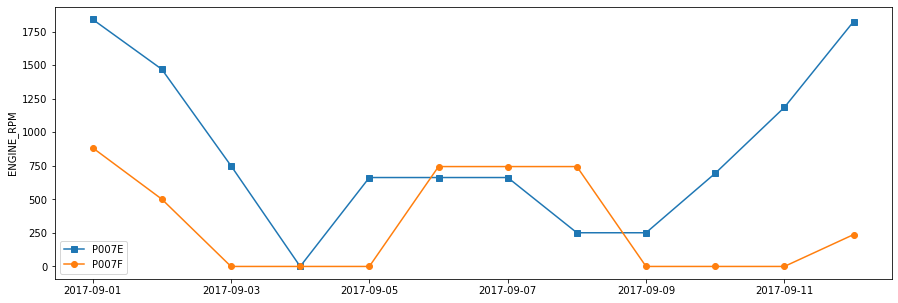

In [35]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['ENGINE_RPM'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['ENGINE_RPM'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('ENGINE_RPM')
plt.show()
# after downsampling
# P007E - sensor value has a dip from sept 1st to sept 4th, and increases after september 9th. 
# P007F - sensor value decreases to 0 until sept 3rd, and follows a seasonal pattern afterwards.

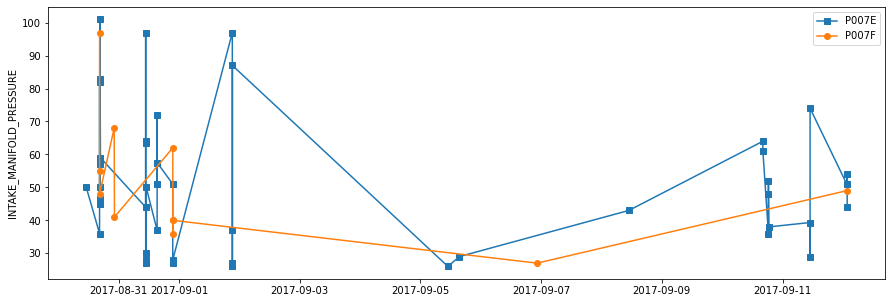

In [36]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['INTAKE_MANIFOLD_PRESSURE'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['INTAKE_MANIFOLD_PRESSURE'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('INTAKE_MANIFOLD_PRESSURE')
plt.show()

#Air pressure is high for both the codes in initial timestamps

In [37]:
mdl4 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['INTAKE_MANIFOLD_PRESSURE']).reshape(-1,1) , y)
mdl4.score(np.array(X['INTAKE_MANIFOLD_PRESSURE']).reshape(-1,1),y)

# checking the accuracy of the classifier to decide on the relationship between sensor data and trouble code's
# accuracy score is low to set up a relationship

0.3448275862068966

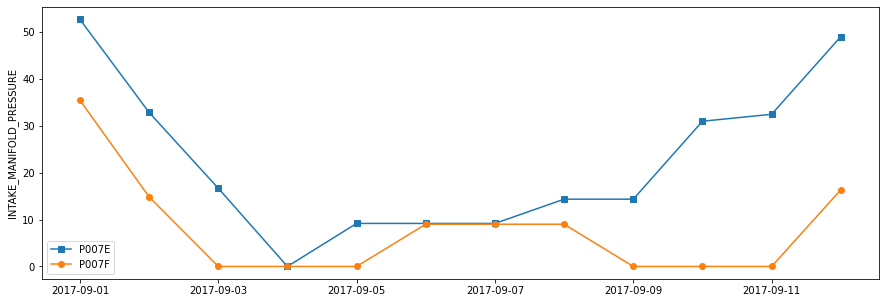

In [38]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['INTAKE_MANIFOLD_PRESSURE'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['INTAKE_MANIFOLD_PRESSURE'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('INTAKE_MANIFOLD_PRESSURE')
plt.show()

# after downsampling
# P007E - sensor value decreases until september 4 and then gradually increases
# P007F - sensor value decreases until september 4, but appears to follow a seasonal pattern afterwards.

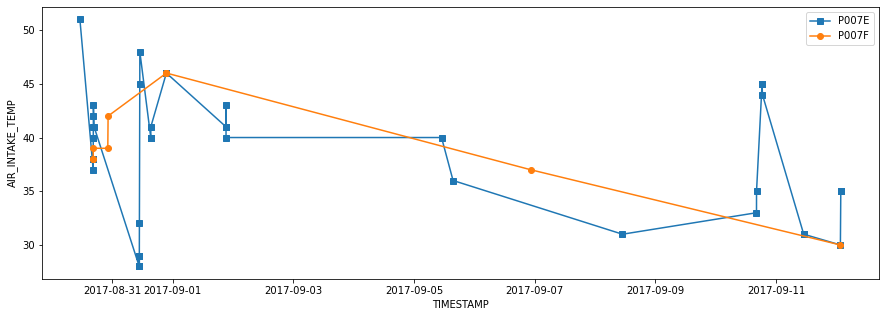

In [39]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['AIR_INTAKE_TEMP'], marker = "s", label = "P007E")
plt.plot(data2['TIMESTAMP'],data2['AIR_INTAKE_TEMP'], marker = "o", label = "P007F")
# plt.scatter(time3,workingset['AIR_INTAKE_TEMP'], c = 'g', marker = "x", label = "other data")
plt.legend(loc='best')
plt.xlabel('TIMESTAMP')
plt.ylabel('AIR_INTAKE_TEMP')
plt.show()

#Intake temperatures are high for initial time stamps for P007E codes.

In [40]:
mdl5 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['AIR_INTAKE_TEMP']).reshape(-1,1) , y)
mdl5.score(np.array(X['AIR_INTAKE_TEMP']).reshape(-1,1),y)

0.43103448275862066

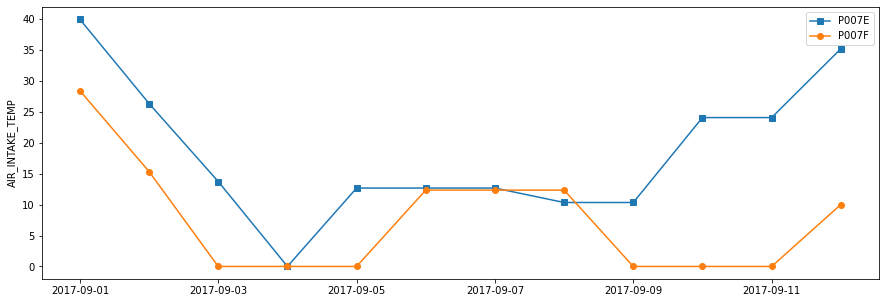

In [41]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['AIR_INTAKE_TEMP'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['AIR_INTAKE_TEMP'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('AIR_INTAKE_TEMP')
plt.show()
# after downsampling
# P007E - sensor value decreases until september 4, and is almost constant with a small dip in september 9th and then increases afterwards. 
# P007F - sensor value decreases until september 4, but appears to follow a seasonal pattern afterwards.

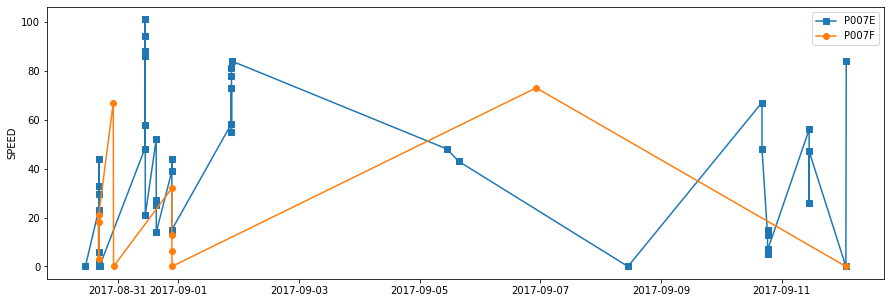

In [42]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['SPEED'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['SPEED'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('SPEED')
plt.show()
# no specific trends are observed.

In [43]:
mdl6 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['SPEED']).reshape(-1,1) , y)
mdl6.score(np.array(X['SPEED']).reshape(-1,1),y)
# checking the accuracy of the classifier to decide on the relationship between sensor data and trouble code's
# accuracy score is low to set up a relationship

0.39655172413793105

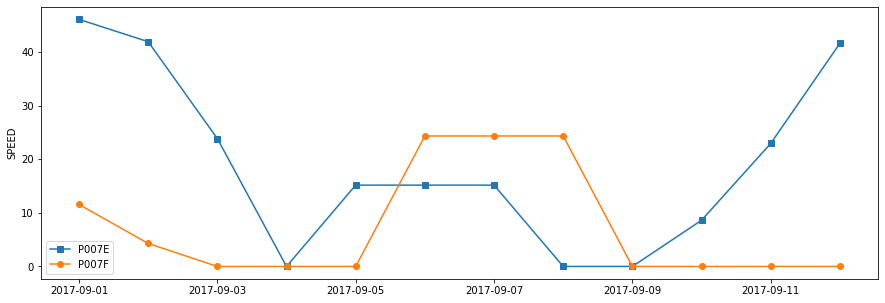

In [44]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['SPEED'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['SPEED'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('SPEED')
plt.show()
# after downsampling
# P007E - sensor value has a dip from sept 1st to sept 4th, and increases after september 9th. 
# P007F - sensor value decreases to 0 until sept 5th, and follows a seasonal pattern afterwards.

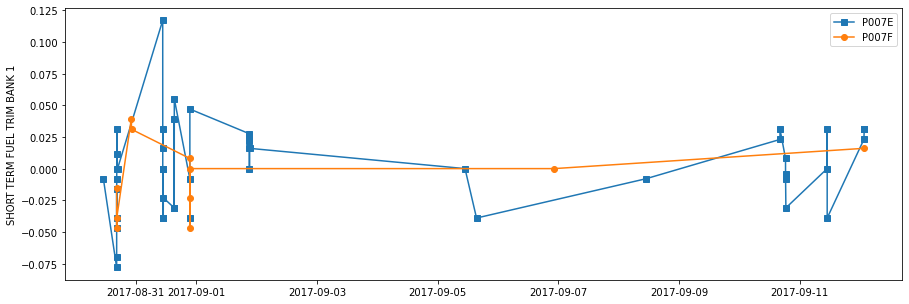

In [45]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['SHORT TERM FUEL TRIM BANK 1'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['SHORT TERM FUEL TRIM BANK 1'], marker = "o", label = 'P007F')
# plt.scatter(time3,workingset['SHORT TERM FUEL TRIM BANK 1'], c = 'g', marker = "x", label = "other data")
plt.legend(loc='best')
plt.ylabel('SHORT TERM FUEL TRIM BANK 1')
plt.show()

# Fuel Trim values for bank1 are in ideal operating ranges for both the codes.

In [46]:
mdl7 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['SHORT TERM FUEL TRIM BANK 1']).reshape(-1,1) , y)
mdl7.score(np.array(X['SHORT TERM FUEL TRIM BANK 1']).reshape(-1,1),y)

0.3448275862068966

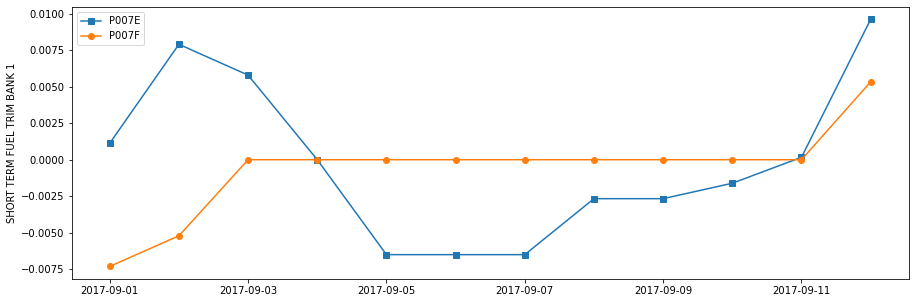

In [47]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['SHORT TERM FUEL TRIM BANK 1'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['SHORT TERM FUEL TRIM BANK 1'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('SHORT TERM FUEL TRIM BANK 1')
plt.show()
# after downsampling
# P007E - sensor value has a dip from sept 3rd to sept 5th, and increases after september 7th. 
# P007F - sensor value increases until sept 3rd, and is constant until september 11th.

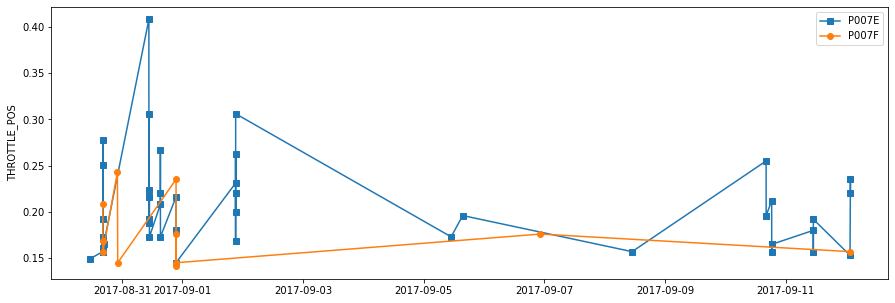

In [48]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['THROTTLE_POS'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['THROTTLE_POS'], marker = "o", label = 'P007F')
# plt.scatter(time3,workingset['THROTTLE_POS'], c = 'g', marker = "x", label = "other data")
plt.legend(loc='best')
plt.ylabel('THROTTLE_POS')
plt.show()

In [49]:
mdl8 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['THROTTLE_POS']).reshape(-1,1) , y)
mdl8.score(np.array(X['THROTTLE_POS']).reshape(-1,1),y)

0.3448275862068966

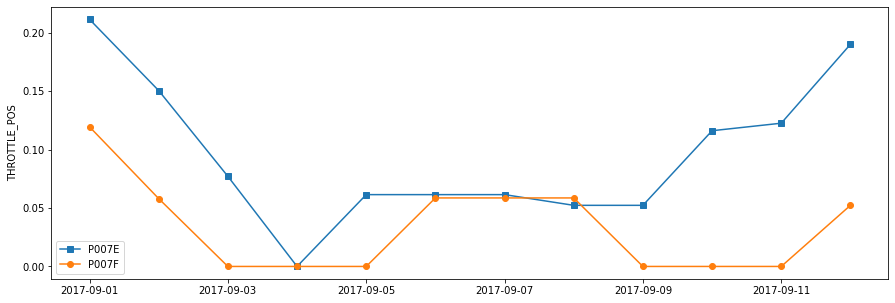

In [50]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['THROTTLE_POS'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['THROTTLE_POS'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('THROTTLE_POS')
plt.show()
# after downsampling - follows the exact trend of 'AIR_INTAKE_TEMP'
# P007E - sensor value decreases until september 4, and is almost constant with a small dip in september 9th and then increases afterwards. 
# P007F - sensor value decreases until september 4, but appears to follow a seasonal pattern afterwards.

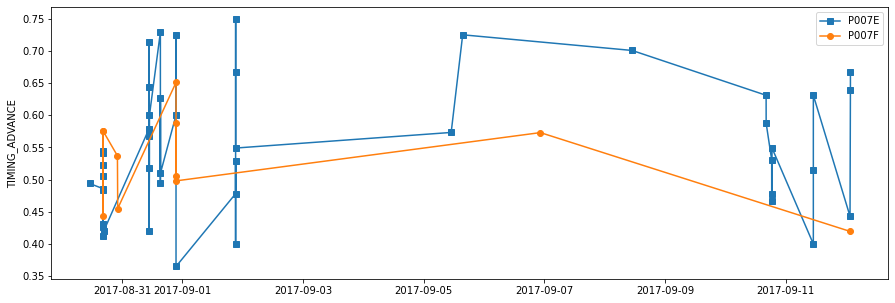

In [51]:
plt.figure(figsize = (15,5))
plt.plot(data1['TIMESTAMP'],data1['TIMING_ADVANCE'], marker = "s", label = 'P007E')
plt.plot(data2['TIMESTAMP'],data2['TIMING_ADVANCE'], marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('TIMING_ADVANCE')
plt.show()

#Timing advances varies widely, especially are higher for P007E codes compared to P007F codes.

In [52]:
mdl9 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(np.array(X['TIMING_ADVANCE']).reshape(-1,1) , y)
mdl9.score(np.array(X['TIMING_ADVANCE']).reshape(-1,1),y)

0.3448275862068966

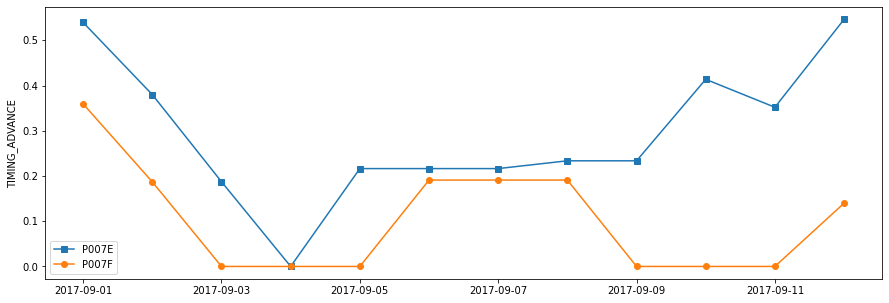

In [53]:
plt.figure(figsize = (15,5))
plt.plot(req_data_1['TIMESTAMP'],req_data_1['TIMING_ADVANCE'].rolling(window=3).mean(), marker = "s", label = 'P007E')
plt.plot(req_data_2['TIMESTAMP'],req_data_2['TIMING_ADVANCE'].rolling(window=3).mean(), marker = "o", label = 'P007F')
plt.legend(loc='best')
plt.ylabel('TIMING_ADVANCE')
plt.show()
# after downsampling - almost follows the trend of 'INTAKE_MANIFOLD_PRESSURE'
# P007E - sensor value decreases until september 4 and then gradually increases
# P007F - sensor value decreases until september 4, but appears to follow a seasonal pattern afterwards.

In [54]:
model1 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter=100000).fit(X, y)
model1.score(X,y)
# when data is used without re-sampling, the accuracy of the classifier is low and requires more iterations to converge to a solution,
# and so, it is not feasible to establish a relationship between sensor data and P007E/F Trouble Codes.

0.46551724137931033

In [55]:
# when data is used without re-sampling, considering case where we have only two classes in our target variable.
data1['TROUBLE_CODES'] = 'P007E'
data2['TROUBLE_CODES'] = 'P007F'
y = list(data1['TROUBLE_CODES']) + list(data2['TROUBLE_CODES'])
model2 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter=100000).fit(X, y)
model2.score(X,y)

0.8103448275862069

In [56]:
X.shape

(58, 9)

In [57]:
req_data.shape

(11925, 11)

In [58]:
model3 = LogisticRegression(random_state=0,solver='lbfgs',multi_class='auto',max_iter = 200).fit(X_resampled , y_resampled)
model3.score(X_resampled, y_resampled)
# data when downsampled gives us more feasibility to establish relationship between sensor data and P007E/F Trouble Codes.

0.6428571428571429

In [59]:
X_resampled.shape

(28, 9)

### Bivariate analysis between the sensor data - for P007E/F trouble codes

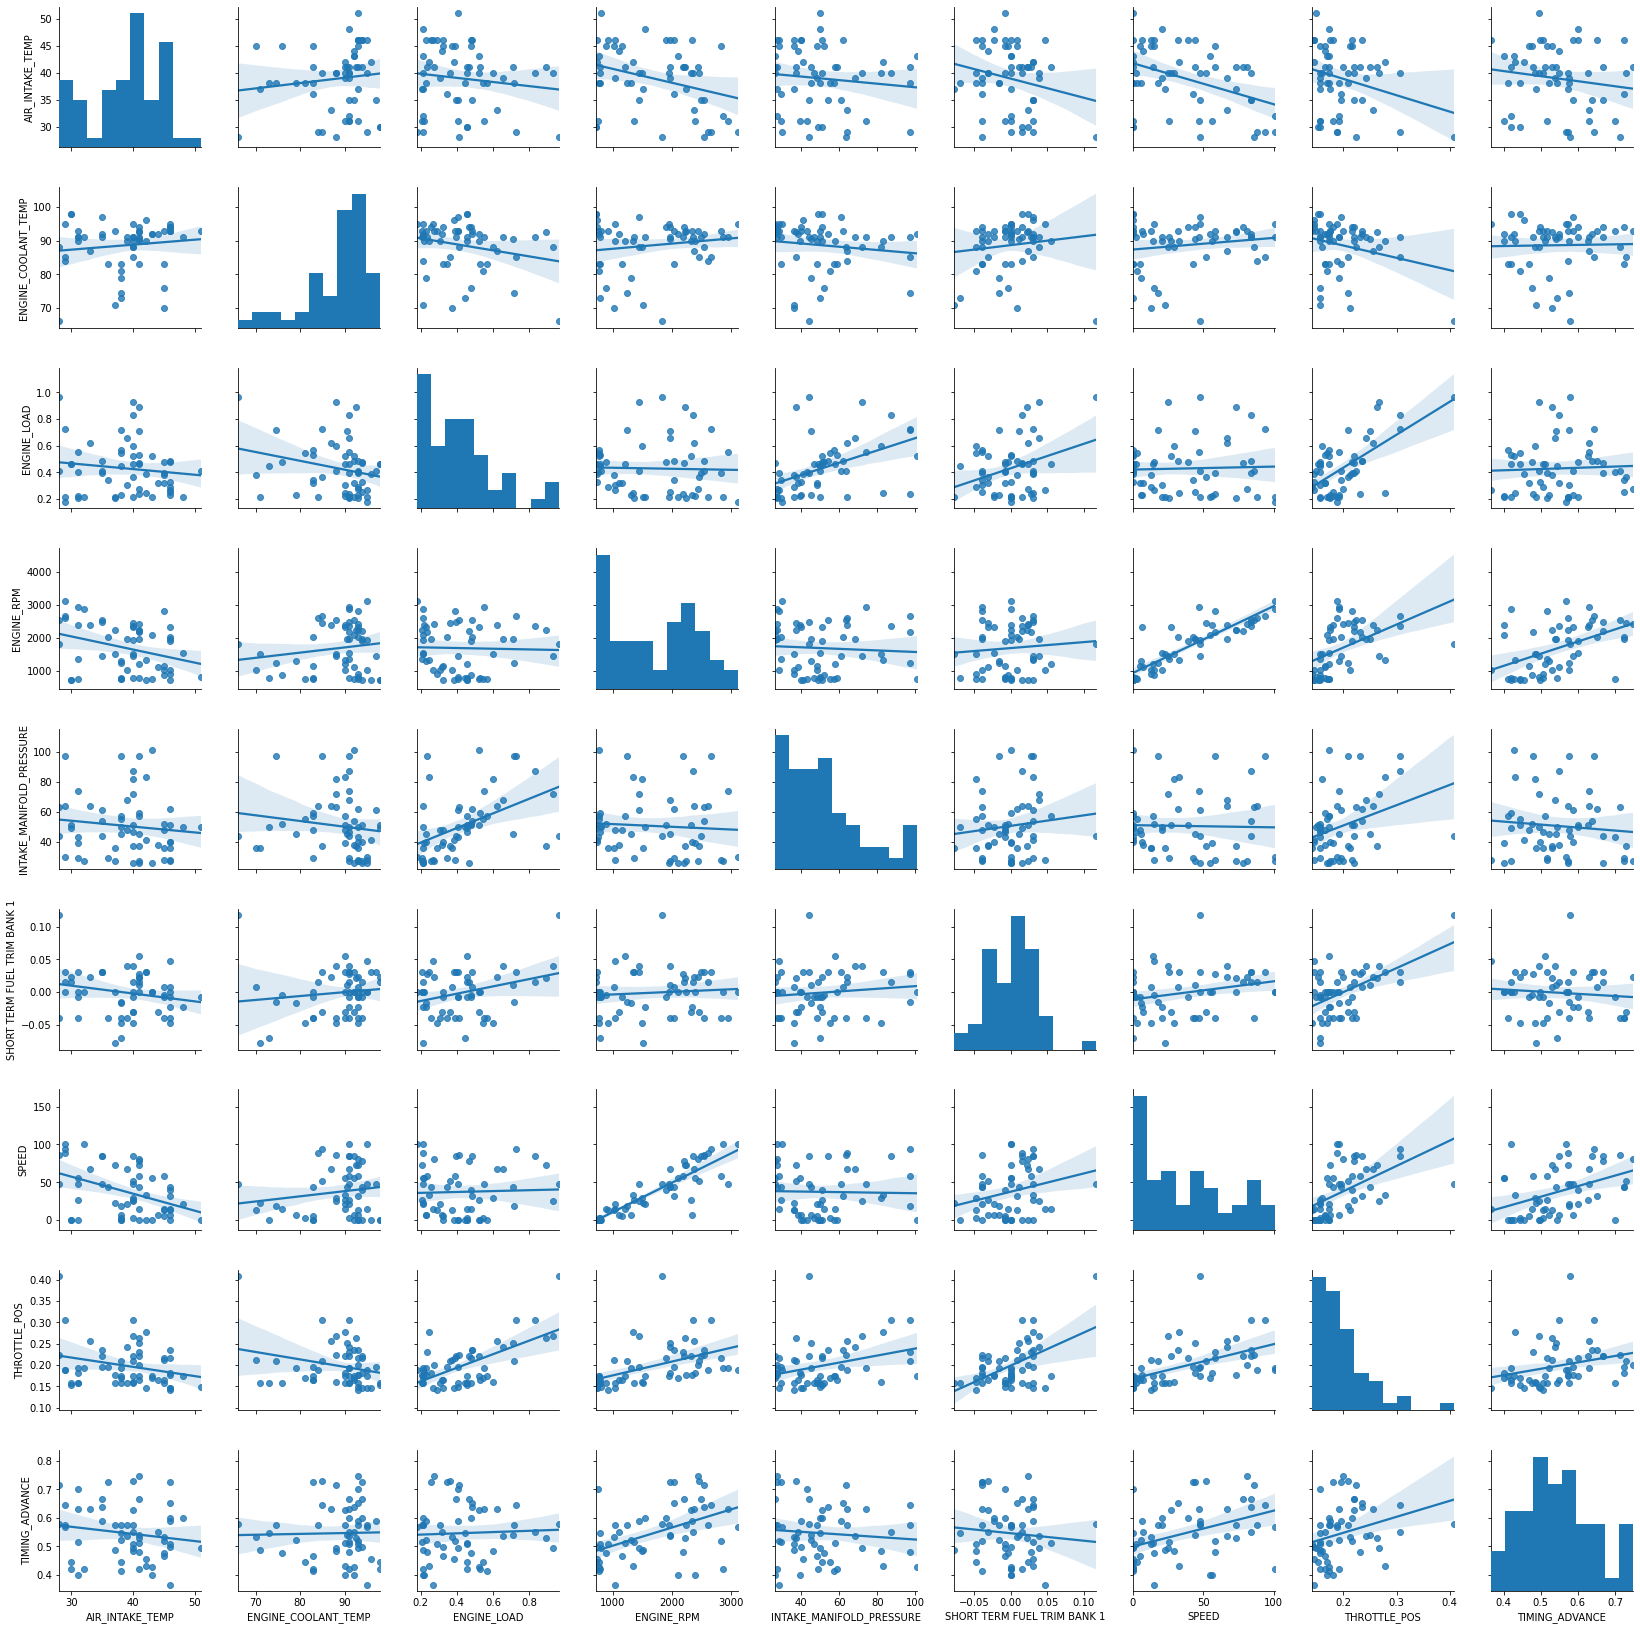

In [60]:
sns.pairplot(X,kind='reg')
# bivariate plots between sensor data before re-sampling

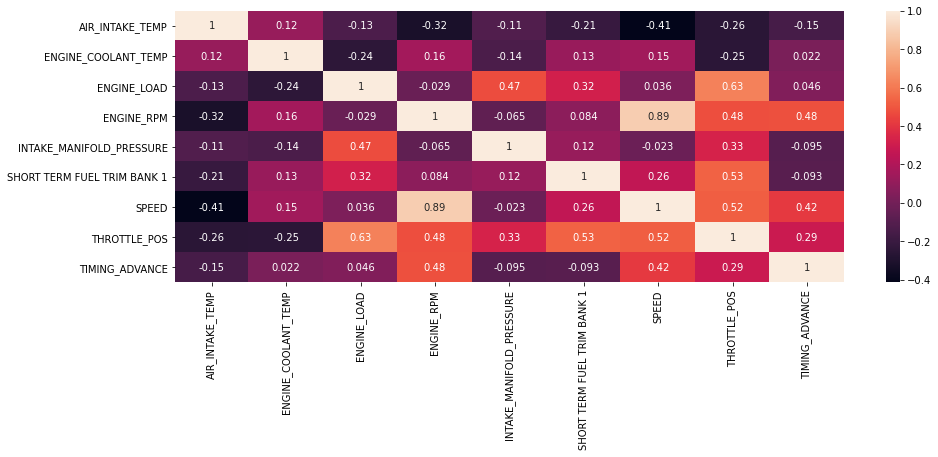

In [61]:
plt.figure(figsize = (15,5))
sns.heatmap(X.corr(),annot=True)

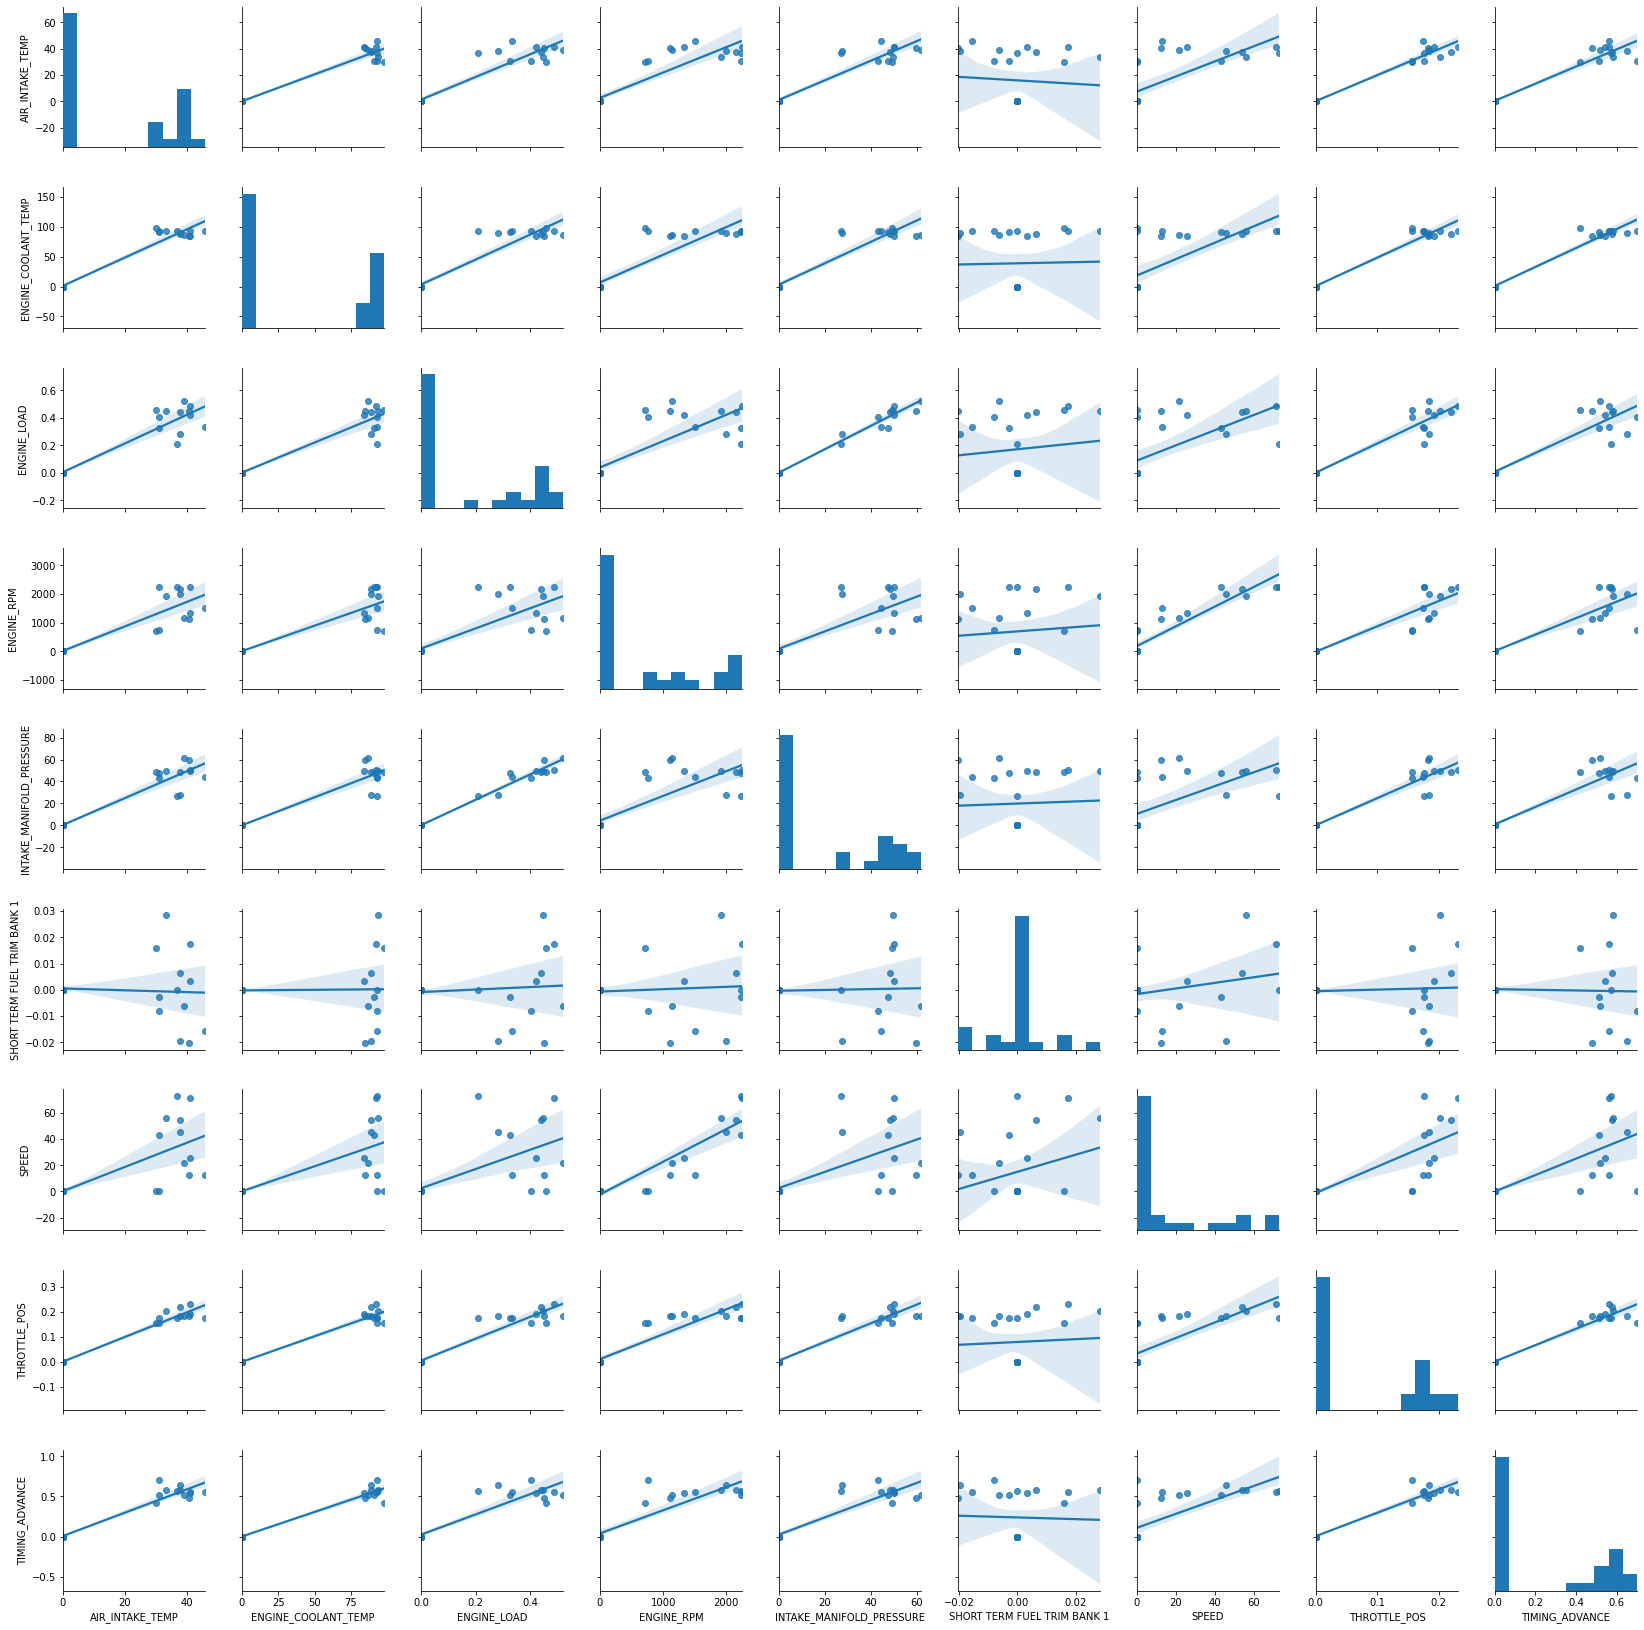

In [62]:
sns.pairplot(X_resampled,kind='reg')
# bi-variate plots between sensor data after downsampling

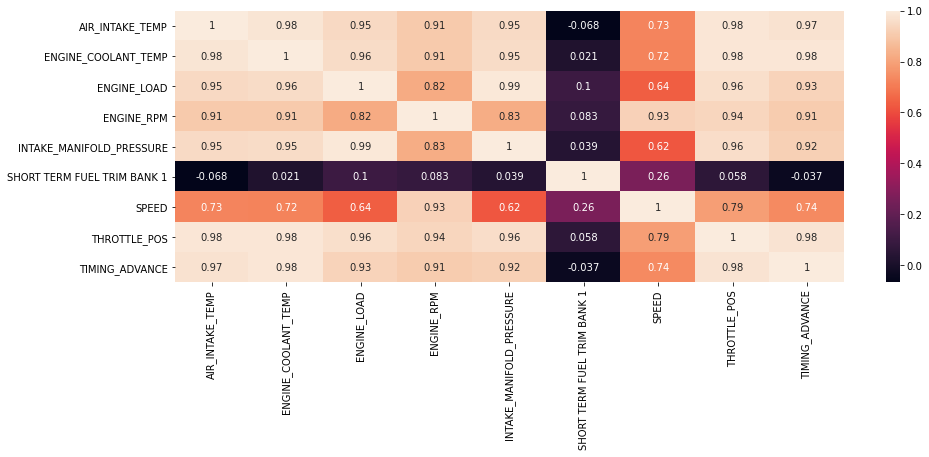

In [63]:
plt.figure(figsize = (15,5))
sns.heatmap(X_resampled.corr(),annot=True)

## Initial Findings from the Data Set

#### 1. Sensor Data is not present for Short Term and Long Term Fuel Trim values for bank 2 , it implies that there is a problem with bank 2 of the engine while codes P007E & P007F are set.

#### 2. There are sensor data’s for short term fuel trim values for bank 1, implies that bank 1 is able to get both fuel and air and also implies that our ECU is working.

#### 3. From the correlation graph, the co-relations between Air Intake temperatures & Engine Coolant Temperature, short term fuel trim bank1 & engine load are varying with time, implies bank 1 is working fine.

#### 4. Normally the charge air cooler temperature sensor values are compared with Intake Air Temperature Sensor values to improve the efficiency of the engine. But, as there are no sensor data’s for MAF(Mass Air Flow) sensor, BAP( Barometric Air Pressure) sensor and Ambient Temperature Sensor(ATC) , implies that there would be disturbances in the charge air cooler (as there are no ATC and MAF values) and air flow into the banks. 

#### 5. On the whole, we could say that there are disturbances in the air flow temperatures (both input and exhaust) in bank 2 of the engine which led to set the codes P007F and P2036. There are also disturbances in the charge air cooler temperature sensors which led to set the code P007E.